In [127]:
import h5py
import os
import glob
import numpy as np
import cv2
from tqdm import tqdm

import rasterio
import cv2
import matplotlib.pyplot as plt
import math


import seaborn as sns
sns.set_context('paper')

In [128]:
BASE_PATH = os.path.join(os.getenv('HOME'), 'workspace/Hackerton') # project folder
DATA_PATH = os.path.join(BASE_PATH, 'RSI_OP_NIA_AIHUB') # data folder

BUILDING_TRAIN_RAW_DIR = os.path.join(DATA_PATH, 'buildings/training/raw')
BUILDING_VAL_RAW_DIR = os.path.join(DATA_PATH, 'buildings/validation/raw')

BUILDING_TRAIN_LABEL_DIR = os.path.join(DATA_PATH, 'buildings/training/label')
BUILDING_VAL_LABEL_DIR = os.path.join(DATA_PATH, 'buildings/validation/label')


H5_FILE = './LV1_DATASET_B_NIR.h5'

B_TRIAN_LIST_TXT = './list/B_train_list.txt'
B_VAL_LIST_TXT = './list/B_val_list.txt'
B_TEST_LIST_TXT = './list/B_test_list.txt'

COLOR_MAP = [
    (165, 42, 42),
    (0, 192, 0),
    (255,255,255)
]

In [129]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(10, 5))
    
    for i, (name, image) in enumerate(images.items()):
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(' '.join(name.split('_')).title())
        axs[i].imshow(image)
        
    plt.tight_layout()
    plt.show()

### 데이터셋 목록 불러오기

In [130]:
import re
with open(B_TRIAN_LIST_TXT) as f:
    train_names = f.readlines()
    train_names = [re.sub('\n', '', name) for name in train_names]
    print(train_names[:3])

with open(B_VAL_LIST_TXT) as f:
    val_names = f.readlines()
    val_names = [re.sub('\n', '', name) for name in val_names]
    print(val_names[:3])

with open(B_TEST_LIST_TXT) as f:
    test_names = f.readlines()
    test_names = [re.sub('\n', '', name) for name in test_names]
    print(test_names[:3])

['BLD00001_PS3_K3A_NIA0276.png', 'BLD00002_PS3_K3A_NIA0276.png', 'BLD00004_PS3_K3A_NIA0276.png']
['BLD00006_PS3_K3A_NIA0276.png', 'BLD00017_PS3_K3A_NIA0276.png', 'BLD00039_PS3_K3A_NIA0276.png']
['BLD00007_PS3_K3A_NIA0276.png', 'BLD00010_PS3_K3A_NIA0276.png', 'BLD00031_PS3_K3A_NIA0276.png']


In [131]:
def tiff_path_to_png_path(path):
    png_path = re.sub('_PS4_', '_PS3_', path)
    png_path = re.sub('tif', 'png', png_path)
    return png_path

def png_path_to_tiff_path(path):
    tif_path = re.sub('_PS3_', '_PS4_', path)
    tif_path = re.sub('png', 'tif', tif_path)
    return tif_path

In [132]:
train_tif_paths = [ os.path.join(BUILDING_TRAIN_RAW_DIR, png_path_to_tiff_path(name)) 
                    for name in train_names]
val_tif_paths = [ os.path.join(BUILDING_TRAIN_RAW_DIR, png_path_to_tiff_path(name)) 
                  for name in val_names]
test_tif_paths = [ os.path.join(BUILDING_VAL_RAW_DIR, png_path_to_tiff_path(name)) 
                   for name in test_names]
tif_paths = {
    'train': train_tif_paths,
    'val': val_tif_paths,
    'test': test_tif_paths
}

In [133]:
train_label_paths = [ os.path.join(BUILDING_TRAIN_LABEL_DIR, name)
                      for name in train_names]
val_label_paths = [ os.path.join(BUILDING_TRAIN_LABEL_DIR, name) 
                    for name in val_names]
test_label_paths = [ os.path.join(BUILDING_VAL_LABEL_DIR, name) 
                     for name in test_names]

label_paths = {
    'train': train_label_paths,
    'val': val_label_paths,
    'test': test_label_paths
}

## NIR and LABEL 데이터셋 저장
---

hdf5 구성
 - group : train
    - dataset : img
    - dataset : label
- group : val
    - dataset : img
    - dataset : label
- group : test
    - dataset : img
    - dataset : label


In [134]:
def reduce_mask(mask, color):
    mask = (mask == color)
    mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
    return mask

In [135]:
with h5py.File(H5_FILE, 'w') as h5:
    for key in ['train', 'val', 'test']:  
        group = h5.create_group(key)
        shape = (len(tif_paths[key]), 1024, 1024)
        group.create_dataset('img', shape, np.float32)
        group.create_dataset('label', shape, np.float32)

        # write the images
        for i in tqdm(range(shape[0]), desc=f'Write {key} image'):
            with rasterio.open(tif_paths[key][i]) as src:
                nir = src.read(4)
                nir = (nir - nir.min()) / (nir.max() - nir.min())*255
            
                label = cv2.cvtColor(cv2.imread(label_paths[key][i]), cv2.COLOR_BGR2RGB)
                label = reduce_mask(label, COLOR_MAP[0])

                group['img'][i, ...] = nir
                group['label'][i, ...] = label

Write test image: 100%|██████████| 159/159 [00:11<00:00, 13.59it/s]


- test

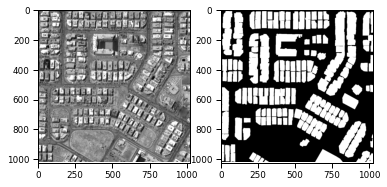

In [136]:
import matplotlib.pyplot as plt

with h5py.File(H5_FILE, 'r') as hdf5_file:
    plt.subplot(121)
    plt.imshow(hdf5_file['test']['img'][10], cmap='gray')
    plt.subplot(122)
    plt.imshow(hdf5_file['test']['label'][10], cmap='gray')
    plt.show()

## SPLIT / FILTERING / SAVE
---

### Functions

In [137]:
def get_slice_pos(split_cnt, STRIDE_SIZE, INPUT_SIZE):
    pts = []
    n = math.sqrt(split_cnt)
    for slice_pos in range(split_cnt):
        pos_i = int(math.floor(slice_pos / n))
        pos_j = int(slice_pos % int(n))
        x = STRIDE_SIZE * pos_i
        y = STRIDE_SIZE * pos_j
        pts.append((x, x+INPUT_SIZE, y, y+INPUT_SIZE))
    return pts

In [138]:
def split_png(img, pts):
    if len(img.shape) == 3:
        sub_imgs = [img[x0:x1, y0:y1, :] for x0, x1, y0, y1 in pts]
    elif len(img.shape) == 2:
        sub_imgs = [img[x0:x1, y0:y1] for x0, x1, y0, y1 in pts]
    return sub_imgs

In [139]:
def filtering(imgs, labels, threshold=1, img_size=256):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    하지만, threshold 미만은 모든 데이터를 지우는 것은 데이터 학습의 효율을 떨어뜨릴 수 있으므로,
    이 과정에 확률을 넣어 1% 확률도 threshold 미만의 데이터가 필터링 되지 않도록 한다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    rand = lambda x: np.random.choice([0, 1], 1, p=[0.99, 0.01])[0]

    label_areas = np.array([label.sum() for label in labels])
    rates = label_areas / (img_size * img_size) * 100
    filter_mask = [True if rate > threshold else rand(0) for rate in rates]
    filtered_imgs = [img for img, mask in zip(imgs, filter_mask) if mask]
    filtered_labels = [label for label, mask in zip(labels, filter_mask) if mask]
    return filtered_imgs, filtered_labels

In [140]:
def split_filtering_save(FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, SPLIT_DIR, pts, img_size=256, split_cnt=25, threshold=1, is_train=True):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    with h5py.File(FILE_PATH, "a") as f:
        # create split dataset ex. FILE[train][split][img], FILE[train][split][label]
        size = f[IMG_PATH].shape[0] * split_cnt
        if 'split' in f[BASE_DIR].keys(): del f[SPLIT_DIR]
        f[BASE_DIR].create_group('split')
        f[BASE_DIR]['split'].create_dataset('img', (size, img_size, img_size), np.float32, maxshape=(size, img_size, img_size))
        f[BASE_DIR]['split'].create_dataset('label', (size, img_size, img_size), np.float32, maxshape=(size, img_size, img_size))
        
        sub_idx = 0
        for i in tqdm(range(f[IMG_PATH].shape[0])):
            # split img with pts(left-top points)
            sub_imgs = split_png(f[IMG_PATH][i], pts)
            
             # split mask with pts
            sub_labels = split_png(f[LABEL_PATH][i], pts)
            
            # filtering labels.
            # after this, the label ratio of less than threshold is filtered out.
            if is_train:
                sub_imgs, sub_labels = filtering(sub_imgs, sub_labels, threshold=threshold, img_size=img_size)
            
            # save imgs and labels in split dataset
            img_len = len(sub_imgs)
            f[SPLIT_DIR]['img'][sub_idx:sub_idx+img_len, ...] = sub_imgs
            f[SPLIT_DIR]['label'][sub_idx:sub_idx+img_len, ...] = sub_labels
            sub_idx += img_len

        # resize dataset
        f[BASE_DIR]['split']['img'].resize((sub_idx, img_size, img_size))
        f[BASE_DIR]['split']['label'].resize((sub_idx, img_size, img_size))

### save

In [141]:
from pathlib import Path

FILE_PATH = H5_FILE

BASE_TARIN_DIR = "/train"
TRAIN_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/img'
TRAIN_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/label'
TRAIN_SPLIT_DIR = f'{Path(BASE_TARIN_DIR)}/split'  
TRAIN_SPLIT_IMG_PATH = f'{Path(BASE_TARIN_DIR)}/split/img'           
TRAIN_SPLIT_LABEL_PATH = f'{Path(BASE_TARIN_DIR)}/split/label'                                                                                                                         

BASE_VAL_DIR = "/val"
VAL_IMG_PATH = f'{Path(BASE_VAL_DIR)}/img'
VAL_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/label'
VAL_SPLIT_DIR = f'{Path(BASE_VAL_DIR)}/split'  
VAL_SPLIT_IMG_PATH = f'{Path(BASE_VAL_DIR)}/split/img'           
VAL_SPLIT_LABEL_PATH = f'{Path(BASE_VAL_DIR)}/split/label'  

BASE_TEST_DIR = "/test"
TEST_IMG_PATH = f'{Path(BASE_TEST_DIR)}/img'
TEST_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/label'
TEST_SPLIT_DIR = f'{Path(BASE_TEST_DIR)}/split'  
TEST_SPLIT_IMG_PATH = f'{Path(BASE_TEST_DIR)}/split/img'           
TEST_SPLIT_LABEL_PATH = f'{Path(BASE_TEST_DIR)}/split/label'

STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

In [142]:
split_filtering_save(FILE_PATH, BASE_TARIN_DIR, TRAIN_IMG_PATH, TRAIN_LABEL_PATH,
                     TRAIN_SPLIT_DIR, pts)

100%|██████████| 1088/1088 [07:58<00:00,  2.27it/s]


In [143]:
split_filtering_save(FILE_PATH, BASE_VAL_DIR, VAL_IMG_PATH, VAL_LABEL_PATH,
                     VAL_SPLIT_DIR, pts)

100%|██████████| 150/150 [00:10<00:00, 14.63it/s]


In [144]:
split_filtering_save(FILE_PATH, BASE_TEST_DIR, TEST_IMG_PATH, TEST_LABEL_PATH,
                     TEST_SPLIT_DIR, pts, is_train=False)

100%|██████████| 159/159 [00:10<00:00, 15.35it/s]


In [148]:
with h5py.File(FILE_PATH, "r") as f:
    print(f.keys())

    print(f['train'].keys())
    print(f['train']['split']['img'])
    print(f['train']['split']['label'])

    print(f['val'].keys())
    print(f['val']['split']['img'])
    print(f['val']['split']['label'])

    print(f['test'].keys())
    print(f['test']['split']['img'])
    print(f['test']['split']['label'])

<KeysViewHDF5 ['test', 'train', 'val']>
<KeysViewHDF5 ['split']>
<HDF5 dataset "img": shape (18516, 256, 256), type "<f4">
<HDF5 dataset "label": shape (18516, 256, 256), type "<f4">
<KeysViewHDF5 ['split']>
<HDF5 dataset "img": shape (2488, 256, 256), type "<f4">
<HDF5 dataset "label": shape (2488, 256, 256), type "<f4">
<KeysViewHDF5 ['split']>
<HDF5 dataset "img": shape (3975, 256, 256), type "<f4">
<HDF5 dataset "label": shape (3975, 256, 256), type "<f4">


In [151]:
FILE_NEW = './LV1_DATASET_B_NIR_2.h5'

In [171]:
with h5py.File(FILE_PATH, "r") as f:
    with h5py.File(FILE_NEW, "w") as nf:
        nf.create_group('train')
        # nf['train'].create_dataset('img', f[TRAIN_SPLIT_IMG_PATH].shape)
        # nf['train'].create_dataset('label', f[TRAIN_SPLIT_LABEL_PATH].shape)

        nf.copy(f[TRAIN_SPLIT_DIR], nf['train'])

        nf.create_group('val')
        # nf['val'].create_dataset('img', f[VAL_SPLIT_IMG_PATH].shape)
        # nf['val'].create_dataset('label', f[VAL_SPLIT_LABEL_PATH].shape)

        nf.copy(f[VAL_SPLIT_DIR], nf['val'])

        nf.create_group('test')
        # nf['test'].create_dataset('img', f[TEST_SPLIT_IMG_PATH].shape)
        # nf['test'].create_dataset('label', f[TEST_SPLIT_IMG_PATH].shape)

        nf.copy(f[TEST_SPLIT_DIR], nf['test'])

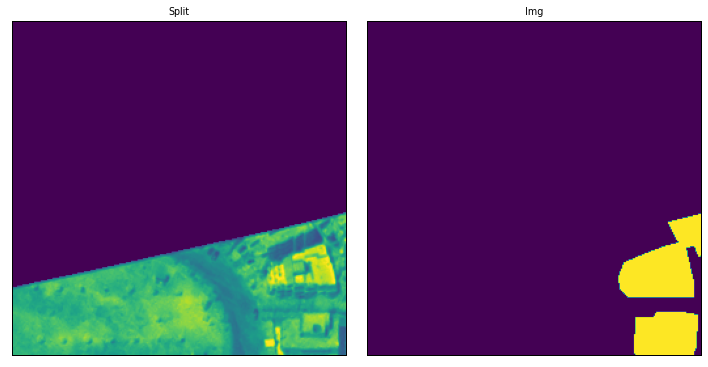

In [177]:
with h5py.File(FILE_NEW, "r") as nf:
    visualize(
        split=nf['train']['split']['img'][0],
        img=nf['train']['split']['label'][0]
    )

#### 면적 분포 확인

100%|██████████| 18513/18513 [16:03<00:00, 19.22it/s]


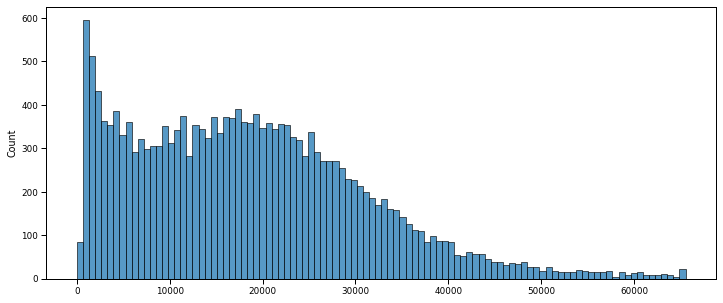

In [102]:
with h5py.File(FILE_PATH, "r") as f:
    img_size = f[TRAIN_SPLIT_LABEL_PATH].shape[0]
    building_areas = [f[TRAIN_SPLIT_LABEL_PATH][i].sum() for i in tqdm(range(img_size))]

plt.figure(figsize=(12,5))
sns.histplot(building_areas, bins=100)
plt.show()

In [44]:
def filtering(imgs, labels, threshold=1, img_size=256):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    rand = lambda x: np.random.choice([0, 1], 1, p=[0.99, 0.01])[0]

    label_areas = np.array([label.sum() for label in labels])
    rates = label_areas / (img_size * img_size) * 100
    filtered_imgs = [img for img, rate in zip(imgs, rates) 
                         if rate > threshold or (rate <= threshold and rand())]
    filtered_labels = [label for label, rate in zip(labels, rates) 
                             if rate > threshold or (rate <= threshold and rand())]
    return filtered_imgs, filtered_labels

In [45]:
def split_filtering_save(FILE_PATH, BASE_DIR, IMG_PATH, LABEL_PATH, SPLIT_DIR, COLOR, pts, img_size=256, split_cnt=25, threshold=1):
    """ label을 조건에 맞게 필터링해주는 함수
    라벨에서 1이 threshold 초과인 것들만을 필터링하여 반환합니다.
    
    Args:
        imgs (list): 잘려진 이미지 목록, labels와 쌍을 이룬다.
        labels (list): 잘려진 라벨 목록, imgs와 쌍을 이룬다.
        threshold (float): 라벨에 포한된 1의 비율(%)이 threshold 이하인 것은 필터링되고 초과인 것들만 남게된다.

    Returns:
        filtered_imgs (list): 필터링된 이미지
        filtered_labels (list): 필터링된 라벨
    """
    with h5py.File(FILE_PATH, "a") as f:
        # create split dataset ex. FILE[train][split][img], FILE[train][split][label]
        size = f[IMG_PATH].shape[0] * split_cnt
        if 'split' in f[BASE_DIR].keys(): del f[SPLIT_DIR]
        f[BASE_DIR].create_group('split')
        f[BASE_DIR]['split'].create_dataset('img', (size, img_size, img_size, 1), np.uint8, maxshape=(size, img_size, img_size, 1))
        f[BASE_DIR]['split'].create_dataset('label', (size, img_size, img_size), np.float32, maxshape=(size, img_size, img_size))
        
        sub_idx = 0
        for i in tqdm(range(f[IMG_PATH].shape[0])):
            # split img with pts(left-top points)
            sub_imgs = split_png(f[IMG_PATH][i], pts)
            
            # extract binary mask from label
            mask = (f[LABEL_PATH][i] == COLOR)
            mask = (mask[:,:,0] +  mask[:,:,1] +  mask[:,:,2]).astype(np.float32)
            
             # split mask with pts
            sub_labels = split_png(mask, pts)
            
            # filtering labels.
            # after this, the label ratio of less than threshold is filtered out.
            filtered_imgs, filtered_labels = filtering(sub_imgs, sub_labels, threshold=1, img_size=img_size)
            
            # save imgs and labels in split dataset
            filted_img_size = len(filtered_imgs)
            f[SPLIT_DIR]['img'][sub_idx:sub_idx+filted_img_size, ...] = filtered_imgs
            f[SPLIT_DIR]['label'][sub_idx:sub_idx+filted_img_size, ...] = filtered_labels
            sub_idx += filted_img_size
            
        # resize dataset
        f[BASE_DIR]['split']['img'].resize((sub_idx, img_size, img_size, 4))
        f[BASE_DIR]['split']['label'].resize((sub_idx, img_size, img_size))

#### sample

In [33]:
STRIDE_SIZE = 192
INPUT_SIZE = 256
SPLIT_CNT = 25
pts = get_slice_pos(SPLIT_CNT, STRIDE_SIZE, INPUT_SIZE)

In [22]:
sample_png_path = os.path.join(BUILDING_TRAIN_RAW_DIR, train_names[0])
sample_tif_path = png_path_to_tiff_path(sample_png_path)
sample_label_path = os.path.join(BUILDING_TRAIN_LABEL_DIR, train_names[0])

print(f'sample_png_path : {sample_png_path}')
print(f'sample_tif_path: {sample_tif_path}')
print(f'sample_label_path: {sample_label_path}')

sample_png_path : /home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS3_K3A_NIA0276.png
sample_tif_path: /home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/raw/BLD00001_PS4_K3A_NIA0276.tif
sample_label_path: /home/aiffel-dj1/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00001_PS3_K3A_NIA0276.png


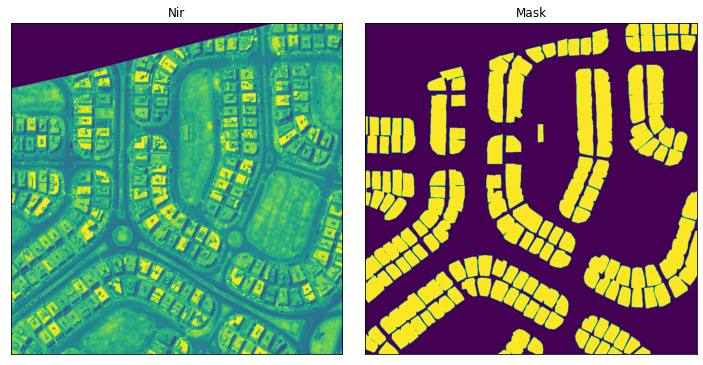

In [26]:
with rasterio.open(sample_tif_path) as src:
    nir = src.read(4)
    nir = (nir - nir.min()) / (nir.max() - nir.min())*255
    nir = np.reshape(nir, (1024, 1024, 1))

    mask = cv2.cvtColor(cv2.imread(sample_label_path), cv2.COLOR_BGR2RGB)
    mask = reduce_mask(mask, COLOR_MAP[0])

    visualize(
        nir=nir,
        mask=mask
    )